In [73]:
%matplotlib inline
from decimal import Decimal
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu, normaltest, norm
from scipy.stats import bootstrap
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import shutil
import random

rng = np.random.default_rng()
# A few helper functions:
#from utils import *

from statannot import add_stat_annotation
#from pandas.compat import StringIO

sns.set(style="whitegrid")

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway

from statannotations.Annotator import Annotator

In [ ]:
#for AO
def make_a_graph_with_order(data, y, x, title, stat_test):
    medians = data.groupby(by=[x], sort=False)[y].median() 
    std = data.groupby(by=[x], sort=False)[y].std() 
    
    my_order = medians.index
    palette = ['black']
    
    #Plot figure
    ###############################################################################################
    plt.figure(figsize=(20, 20))
    sns.set_context("paper", rc={"font.size":50,"axes.titlesize":50,"axes.labelsize":25})
    
    ###############################################################################################
    #draw dots
    bplot = sns.stripplot(y=y, x=x,  size=15,
                data=data, palette="rocket",hue="Cell")
      
    #draw errorbars 1sigma
    bplot = sns.pointplot(y=y, x=x, 
                 data=data,
                 join=False,
                 errorbar=("sd", 1), 
                 n_boot=5000, seed=10,  #unused for sd
                 errwidth=5,
                 capsize=0.1,
                 scale=0,
                 palette = ['#929591']
                 )
    
    bplot = sns.violinplot(y=y, x=x, 
                 data=data, 
                 #hue="date",
                 #capsize=0.1,
                 #scale=0,
                 bw=1.2,
                 #cut=1,
                 inner=None,#,size=20,
                 palette = ['#E6E6FA', '#E6E6FA','#FFFF00',
                            '#FFFF00', '#FFFF00', '#FFFF00',]
                )
            
    #draw meanline
    sns.pointplot(y=y, x=x, data=data, join=False, ci=0, capsize=0.3, scale=0, errwidth=5, palette = ['#929591']) #hue="date", dodge=0.45, linewidth`, `markersize instead of scale
    
    #draw curve line
    df_wide = data.pivot_table(index="Experiment", columns="Cell", values="Nuc/cyto TFEB-GFP fluorescence",sort=False)
    bplot = sns.lineplot(df_wide, palette="rocket",dashes=False,legend=False,sizes=(105, 205))    
    
    # '#e41a1c', '#4daf4a', '#377eb8' RGB
    # '#377eb8', '#ff7f00', '#4daf4a', Blue Orange Green
    # '#f781bf', '#a65628', '#984ea3', violet
    # '#999999', '#e41a1c', '#dede00' grey red yellow
    # inner{“box”, “quartile”, “point”, “stick”, None}, optional
    # Representation of the datapoints in the violin interior. If box, draw a miniature boxplot. If quartiles, draw the quartiles of the distribution. 
    # If point or stick, show each underlying datapoint. Using None will draw unadorned violins.
    
    
    #########################################################################################################################
    #Customize labels
    #########################################################################################################################
    #not show X column name
    bplot.set_xlabel(str(x), fontsize=0)
    bplot.set_ylabel(str(y), fontsize=40)
    
    #bplot.ticklabel_format(axis='y', style='sci', scilimits=(1,0))
    #ylabels = ['{:,.1f}'.format(y) for y in bplot.get_yticks()]#+ 'E+05'
    
    bplot.tick_params(labelsize=40)
    bplot.set_xticklabels(bplot.get_xticklabels(), rotation=30, fontsize=40)
    bplot.legend(fontsize=25,markerscale=3,loc='upper right')
 
    bplot.set_ylim(-0.05, 5)
    #ymin, ymax = data[y].min(), data[y].max()
    #bplot.set_ylim(ymin * 0.9, ymax * 1.1)
     
    #########################################################################################################################
    #draw number of experiments, mean, 
    N = data.groupby(by=[x], sort=False).size() 
    plt.text(-1.5, -1, 'median', fontsize=40) 
    plt.text(-1.5, -1.4, 'N cells', fontsize=40)
    # for i in range(0, 9):
    #     plt.text(i-0.1, -1.9, N.iloc[i], fontsize=55)
    #     plt.text(i-0.1, -1.5, round(medians.iloc[i],1), fontsize=55)

    for i, grp in enumerate(my_order):
        plt.text(i+0.1, -1.4, f"{N[grp]}", fontsize=40, ha="center")
        plt.text(i+0.1, -1, f"{medians[grp]:.1f}", fontsize=40, ha="center")

    #########################################################################################################################    

   
        #Stars
    #########################################################################################################################
    box_pairs=[('0', '10'),
               ]
    
    #['full', 'simple', 'star'] for argument `text_format`
    #t-test_ind, t-test_welch, t-test_paired, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal
    
    # build the annotator on the same axes you plotted to
    annotator = Annotator(
        ax=bplot,
        pairs=box_pairs,
        data=data,
        x=x,
        y=y,
        order=my_order
    )

    annotator.configure(
        test=stat_test,         # e.g. "t-test_ind"
        text_format='star',     # keeps your star notation
        comparisons_correction=None,
        loc='inside',           # same placement
        fontsize=60
    )
    annotator.apply_and_annotate()

    #Arrow
    bplot.annotate(
        "Light ON",          # the text label
        xy=(1, 0),          # arrow “head” at (x, y)
        xytext=(1, -1),      # text at (x0, y0)
        va='bottom',
        ha='center',
        arrowprops=dict(
            arrowstyle="->",  # try "-|>, head_length=0.5" etc.
            color="red",
            lw=10
        ),
        fontsize=40,
        clip_on=False 
    )

    #box
    # bplot.annotate(
    # "",
    # xy=(1, 0.8),            # one corner in axes fraction
    # #xycoords='axes fraction',
    # xytext=(4, 0.3),        # opposite corner
    # #textcoords='axes fraction',
    # arrowprops=dict(
    #     arrowstyle='-[,widthB=1.0',  # fancy bracket‐style rectangle
    #     linewidth=10,
    #     color='purple'
    # ),
    # annotation_clip=False
    # )
    

    #Get same yellow color
    yellow = sns.color_palette("rocket", 256)[-1]
    yellow_hex = mcolors.to_hex(yellow)

    rect = patches.Rectangle(
    (1, -0.6),    # lower‐left corner at x=1.2, y=0.5
    width=3,
    height=0.1,
    linewidth=2,
    edgecolor='#E6E6FA',
    facecolor=yellow_hex,
    alpha=1,      # semi-transparent fill
    clip_on=False
    )

    # 3) Add it to your Axes
    bplot.add_patch(rect)


    print('####')
    print(medians)
    print('####')
    print('####')
    print(my_order)
    print('####')




In [71]:
df_pmA3_TFEB = pd.read_excel('../data/03_14/LED/after/2_TS_f.xlsx')
df_pmA3_TFEB['Experiment'] = df_pmA3_TFEB['Experiment'].astype(str)

C:\Users\lliza\AppData\Local\Temp\ipykernel_21140\716515248.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bplot = sns.pointplot(y=y, x=x,
C:\Users\lliza\AppData\Local\Temp\ipykernel_21140\716515248.py:20: UserWarning: 
The palette list has fewer values (1) than needed (6) and will cycle, which may produce an uninterpretable plot.
  bplot = sns.pointplot(y=y, x=x,
C:\Users\lliza\AppData\Local\Temp\ipykernel_21140\716515248.py:20: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  bplot = sns.pointplot(y=y, x=x,
C:\Users\lliza\AppData\Local\Temp\ipykernel_21140\716515248.py:20: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line be

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0 vs. 10: t-test independent samples, P_val:9.330e-01 t=8.502e-02
####
Experiment
0     1.518811
2     1.548285
10    1.344775
20    1.424444
32    1.307253
45    1.443972
Name: Nuc/cyto TFEB-GFP fluorescence, dtype: float64
####
####
Index(['0', '2', '10', '20', '32', '45'], dtype='object', name='Experiment')
####


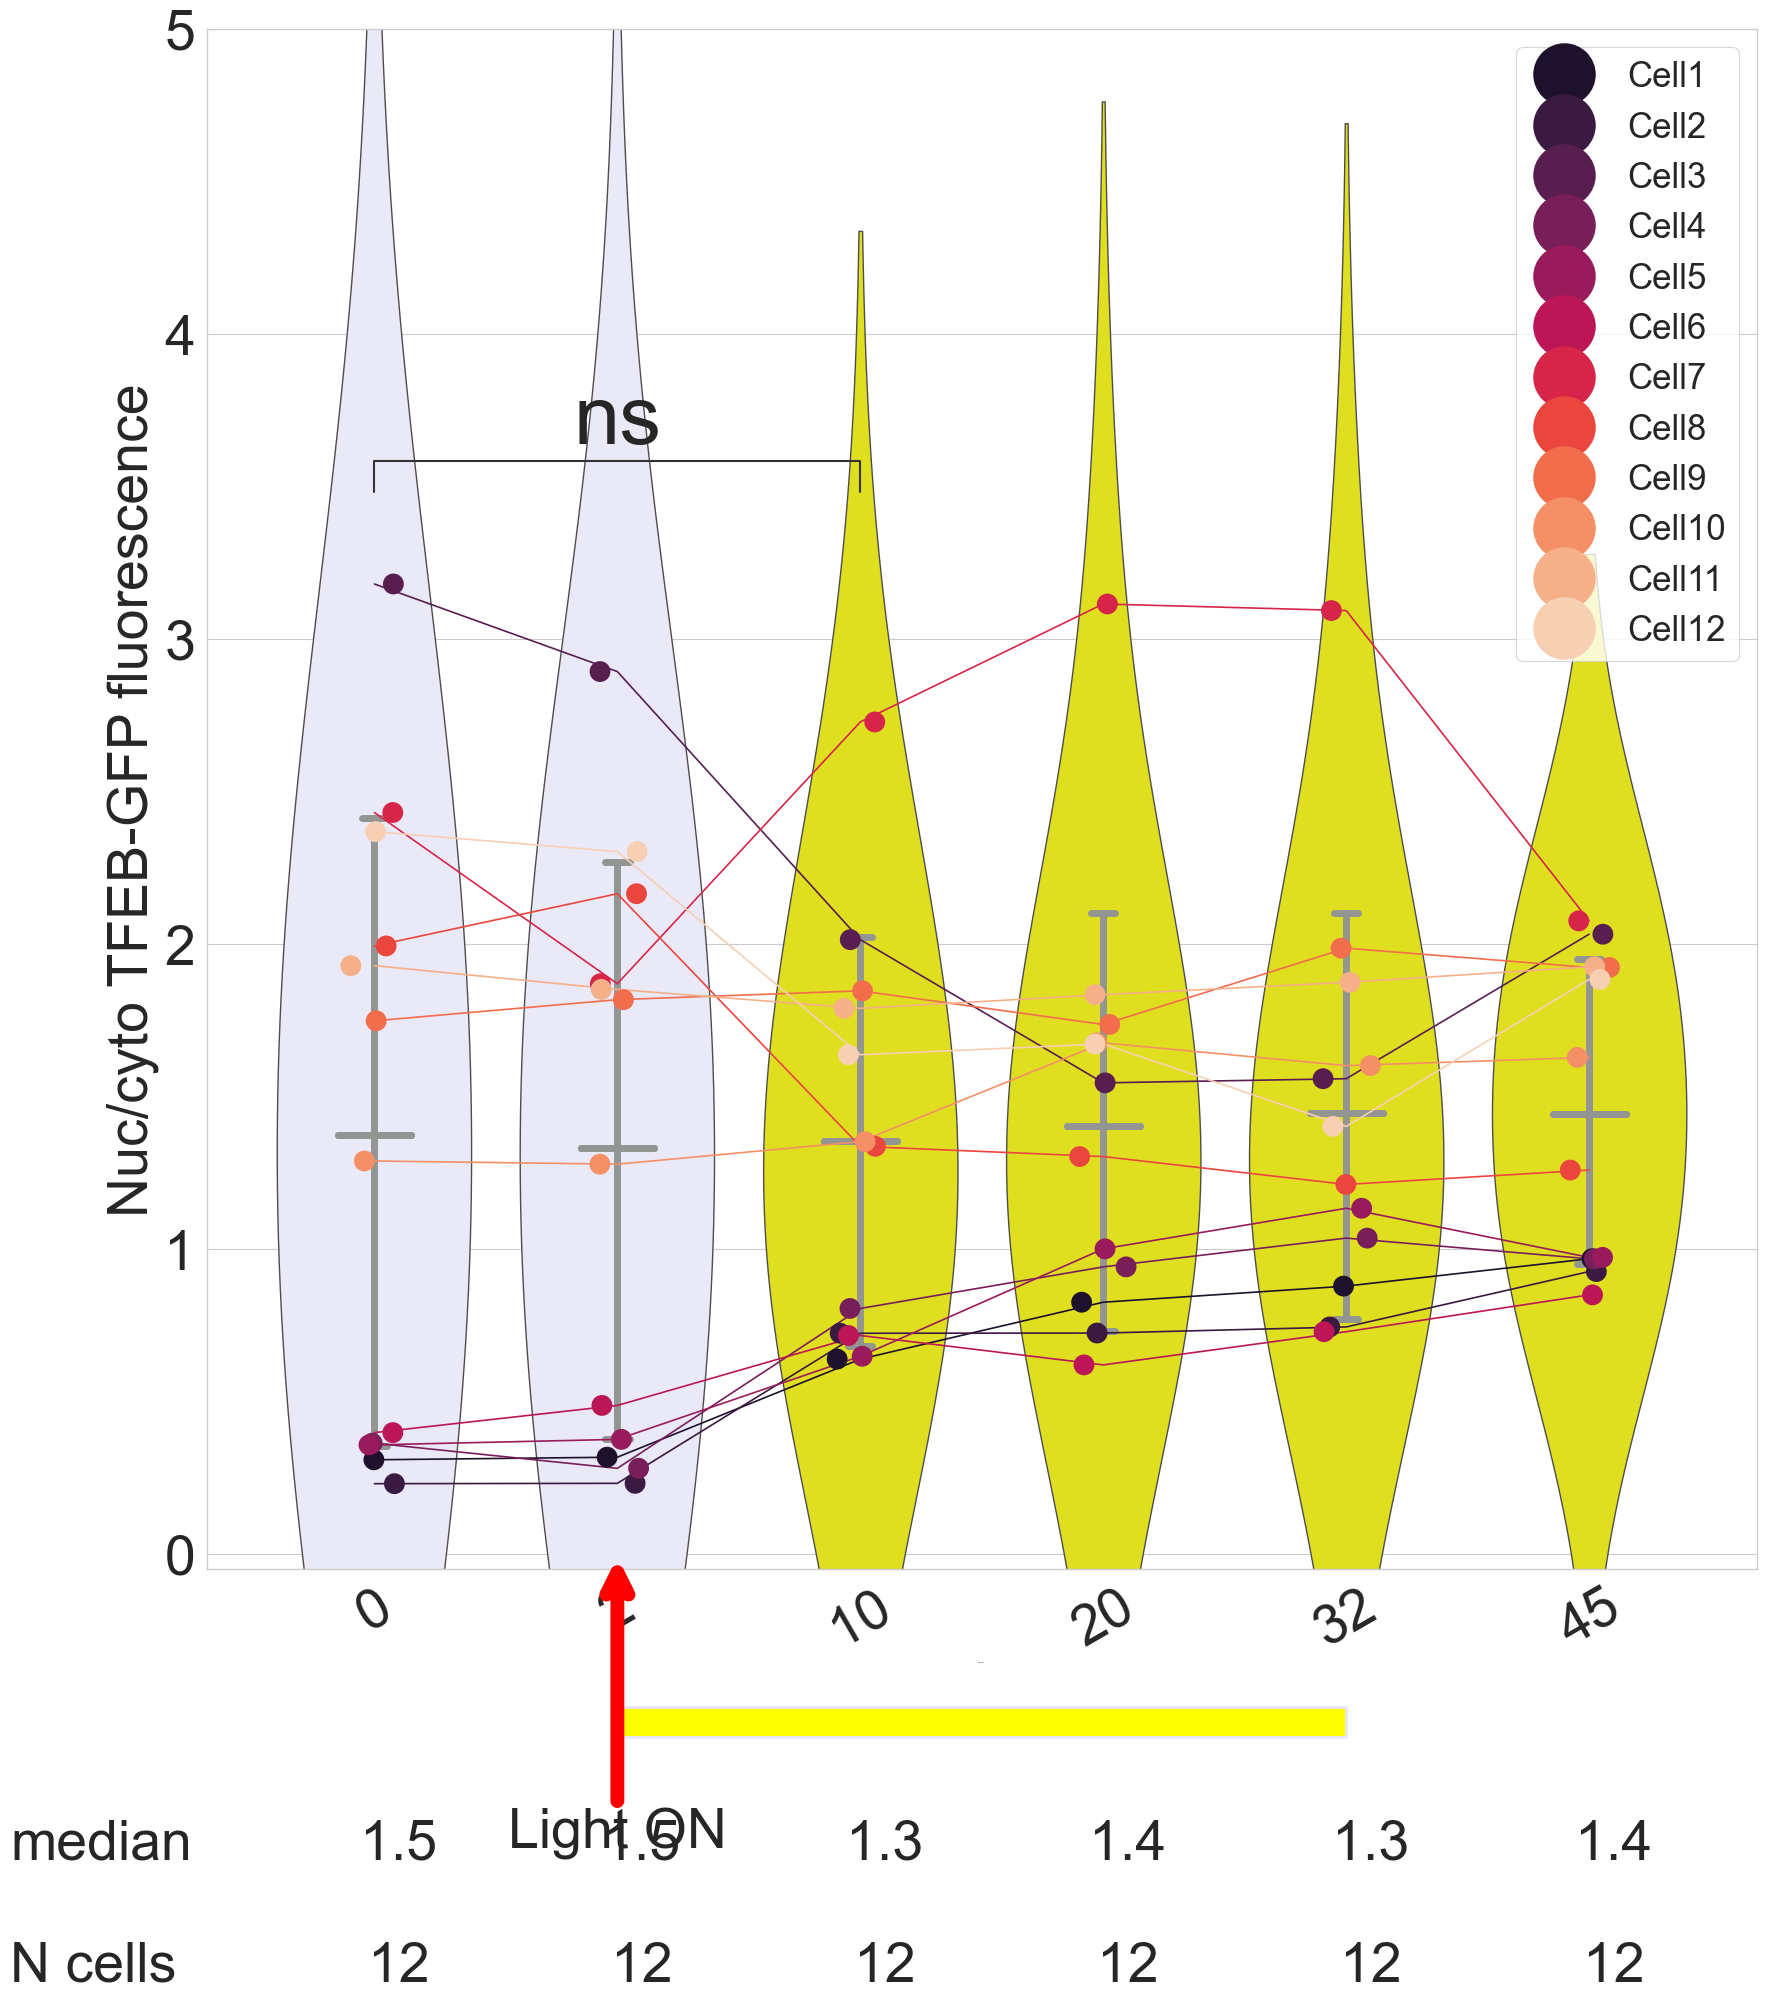

In [72]:
make_a_graph_with_order(df_pmA3_TFEB, "Nuc/cyto TFEB-GFP fluorescence", 'Experiment', '','t-test_ind')
plt.savefig('2_TS_03_14.jpg', bbox_inches = "tight", dpi=300) 